# 1. Problem Statement

Develop a forecasting model to accurately predict the future prices of crude oil based on historical data, market trends, and other relevant variables. The model should consider the impact of various factors such as geopolitical events, economic indicators, supply and demand dynamics, and changes in government policies. The goal of this model is to provide reliable and accurate forecasts of crude oil prices, enabling stakeholders in the energy industry to make informed decisions regarding production, investment, trading, and risk management.

Importing required libraries and Modules

In [407]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import itertools

from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error

# statsmodels library
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#For LSTM
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM, Input
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.optimizers import Adam

#To install the Prophet API
#pip install prophet

#Importing Libraries for prophet
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly

#For saving and loading model in json format
from keras.models import model_from_json

#2. Importing DataSet

We are using Crude Oil prices from website https://in.investing.com/commodities/crude-oil-historical-data.
Data is collected and stored in CSV file.


In [275]:
# Reading data from csv file and store in dataframe
oil_price_data=pd.read_csv('Crude_Oil_Price_2000_2023.csv')

#3.	Data Preview and Understanding

In [276]:
# First 10 rows of Data
oil_price_data.head(10)

,Date,Price
0,14-Aug-23,82.14
1,13-Aug-23,82.90
2,11-Aug-23,83.19
3,10-Aug-23,82.82
4,09-Aug-23,84.40
5,08-Aug-23,82.92
6,07-Aug-23,81.94
7,04-Aug-23,82.82
8,03-Aug-23,81.55
9,02-Aug-23,79.49


In [277]:
# Last 10 rows of data
oil_price_data.tail(10)

,Date,Price
6044,18-Jan-00,28.85
6045,14-Jan-00,28.02
6046,13-Jan-00,26.69
6047,12-Jan-00,26.28
6048,11-Jan-00,25.77
6049,10-Jan-00,24.67
6050,07-Jan-00,24.22
6051,06-Jan-00,24.78
6052,05-Jan-00,24.91
6053,04-Jan-00,25.55


In [278]:
#Shape of the data set, No of rows and columns
oil_price_data.shape

(6054, 2)

Observation : Data Set has 6054 rows and 2 columns Date & Price.
Data is stored sequentially starting from 14-Aug-2023 to 04-Jan-2000  

# 4. Exploratory data analysis (EDA)

###Summerized Information about Dataset

In [279]:
# DataSet summarized information
oil_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6054 non-null   object 
 1   Price   6054 non-null   float64
dtypes: float64(1), object(1)
memory usage: 94.7+ KB


###Descriptive Analysis

In [280]:
#Statistics Summary
oil_price_data.describe()

,Price
count,6054.000000
mean,63.007618
std,25.745921
min,-37.630000
25%,42.840000
50%,60.680000
75%,82.440000
max,145.290000


Observation : Price column has values in Normal range with Average value 63.0

In [281]:
#Median of Price column
oil_price_data.median()

Price    60.68
dtype: float64

In [282]:
#Mode of Price column
oil_price_data.Price.mode()

0    30.35
1    44.66
Name: Price, dtype: float64

### Duplicate Values

In [283]:
#Count of duplicated rows
oil_price_data[oil_price_data.duplicated()].shape

(0, 2)

Observation : No duplicate values in Dataset

###Data Type Conversion

In [284]:
#Data Types
oil_price_data.dtypes

Date      object
Price    float64
dtype: object

In [285]:
# Date Column is having object/string data type. We will convert it to DateTime type.
oil_price_data['Date']=pd.to_datetime(oil_price_data['Date'], errors='coerce')

In [286]:
oil_price_data.head()

,Date,Price
0,2023-08-14,82.14
1,2023-08-13,82.90
2,2023-08-11,83.19
3,2023-08-10,82.82
4,2023-08-09,84.40


###Setting Index

In [287]:
#As this is a Time Series Data set, We will set Date column as index
oil_price_series=oil_price_data.set_index('Date')
oil_price_series.head()

,Price
Date,
2023-08-14,82.14
2023-08-13,82.90
2023-08-11,83.19
2023-08-10,82.82
2023-08-09,84.40


###Change the order of data

In [288]:
oil_price_series=oil_price_series.sort_index(axis=0,ascending=True)
oil_price_series.head()

,Price
Date,
2000-01-04,25.55
2000-01-05,24.91
2000-01-06,24.78
2000-01-07,24.22
2000-01-10,24.67


###Missing Values and Imputation

In [289]:

#As observed we have 2 days are missing weekly in our dataset
start = oil_price_series.index[0].date()
end = oil_price_series.index[len(oil_price_series)-1].date()
new_dates = pd.date_range(start=start,end=end,freq='D')
oil_price_series = oil_price_series.reindex(new_dates)
oil_price_series = oil_price_series.rename_axis('Date')

In [290]:
oil_price_series

,Price
Date,
2000-01-04,25.55
2000-01-05,24.91
2000-01-06,24.78
2000-01-07,24.22
2000-01-08,NaN
...,...
2023-08-10,82.82
2023-08-11,83.19
2023-08-12,NaN


###Imputation using Last Observation Carried Forward (LOCF)

In [291]:
oil_price_series['Price']=oil_price_series['Price'].fillna(method ='ffill')
oil_price_series.head(10)

,Price
Date,
2000-01-04,25.55
2000-01-05,24.91
2000-01-06,24.78
2000-01-07,24.22
2000-01-08,24.22
2000-01-09,24.22
2000-01-10,24.67
2000-01-11,25.77
2000-01-12,26.28


###Rename column

In [292]:
#No need to rename columns

##Outlier Detection and Removal

<Axes: >

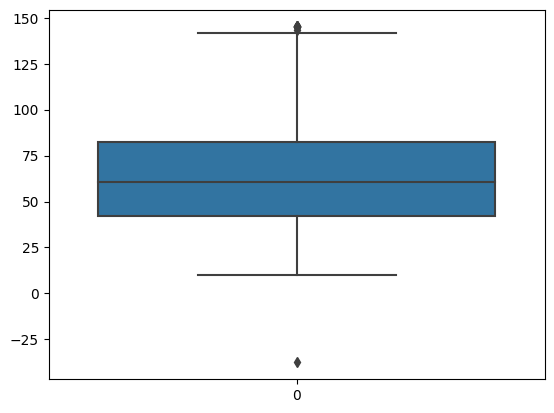

In [293]:
# Boxplot for outliers
sns.boxplot(oil_price_series.Price)

Observation : We can see some outliers present in dataset. As this is time series we cant directly remove the outliers.

###Capping Method to impute the outliers

In [294]:
#First Quartile
Q1 = oil_price_series.Price.quantile(0.25)
#Third Quarile
Q3 = oil_price_series.Price.quantile(0.75)

#IQR
iqr=Q3-Q1
print('IQR ', iqr)

#lower and upper bound
lower_bound = Q1-1.5 * iqr
upper_bound= Q3+ 1.5 * iqr
print(lower_bound)
print(upper_bound)

IQR  40.3625
-18.401249999999997
143.04874999999998


In [295]:
#Outlier detection
print(oil_price_series[oil_price_series['Price'] > upper_bound])
print(oil_price_series[oil_price_series['Price'] < lower_bound])

             Price
Date              
2008-07-02  143.57
2008-07-03  145.29
2008-07-04  145.29
2008-07-05  145.29
2008-07-06  145.29
2008-07-11  145.08
2008-07-12  145.08
2008-07-13  145.08
2008-07-14  145.18
            Price
Date             
2020-04-20 -37.63


Observation : We can see 10 outliers are present.

In [296]:
#Creating copy of dataframe
cleaned_oil_price_series=oil_price_series.copy()

# Capping or imputing outliers with upper_bound and lower_bound
cleaned_oil_price_series['Price'] = np.where(cleaned_oil_price_series['Price'] > upper_bound,upper_bound,
                       np.where(cleaned_oil_price_series['Price'] < lower_bound, lower_bound, cleaned_oil_price_series['Price']))

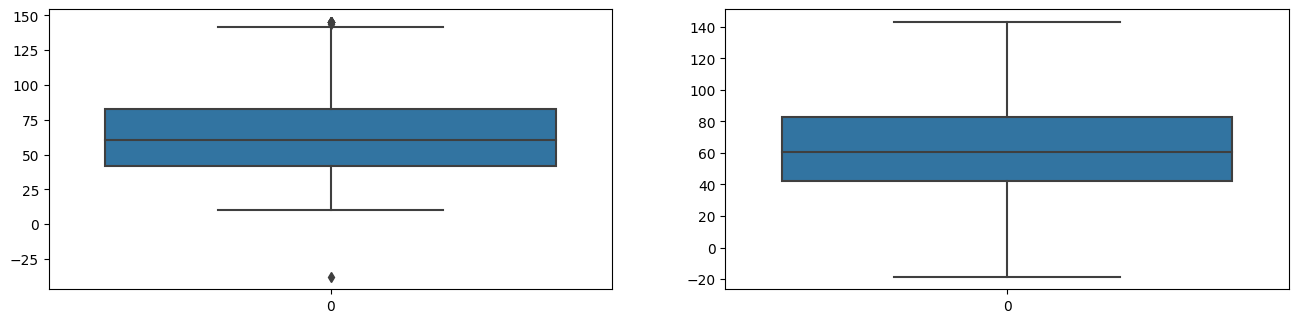

In [297]:
# Compare the plots after Outliers removal
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.boxplot(oil_price_series['Price'])
plt.subplot(2,2,2)
sns.boxplot(cleaned_oil_price_series['Price'])
plt.show()


Observation : Common Outliers have been capped with lower and upper bound.

<Axes: xlabel='Date', ylabel='Price'>

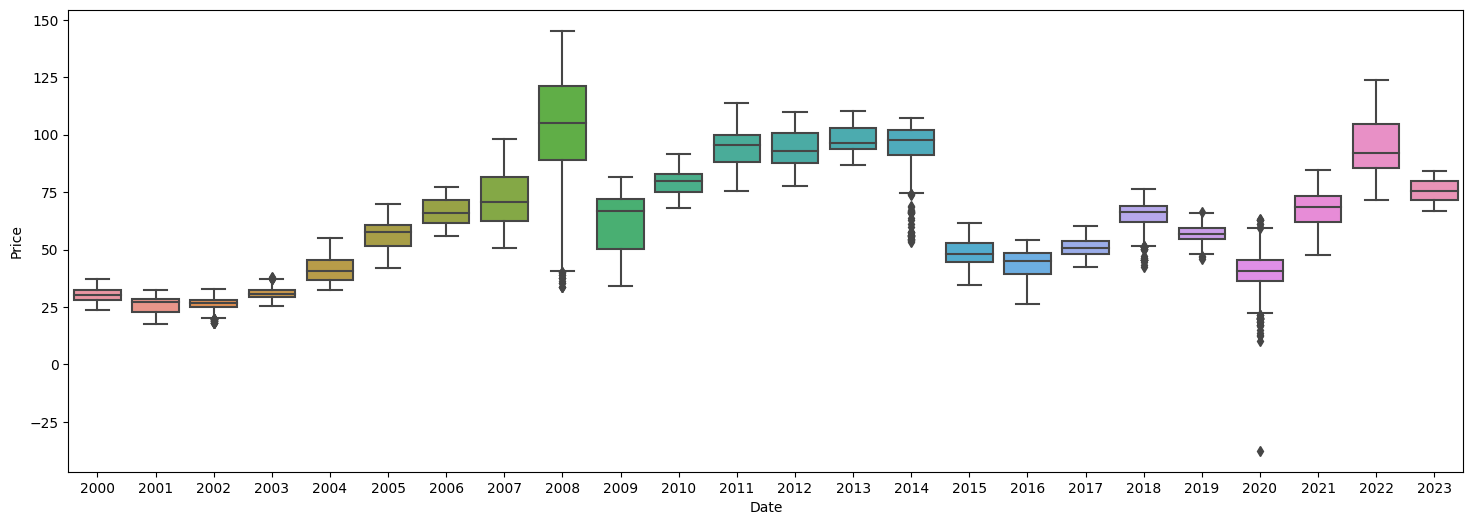

In [298]:
plt.figure(figsize=(18,6))
# Boxplot for outliers
sns.boxplot(x=cleaned_oil_price_series.index.year,y=oil_price_series.Price)

In [299]:
#Capping outliers
def cap_year_month_wise_outliers(data):
    Q1 = data['Price'].quantile(0.25)
    Q3 = data['Price'].quantile(0.75)
    iqr = Q3 - Q1

    lower_bound = Q1 - 1.5 * iqr
    upper_bound = Q3 + 1.5 * iqr

    data['Price'] = data['Price'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return data

# Group data by year and apply yearwise capping method

cleaned_oil_price_series= cleaned_oil_price_series.groupby(cleaned_oil_price_series.index.year).apply(cap_year_month_wise_outliers)

# Group data by month and apply Month wise capping method

cleaned_oil_price_series= cleaned_oil_price_series.groupby(cleaned_oil_price_series.index.month).apply(cap_year_month_wise_outliers)

<Axes: xlabel='Date', ylabel='Price'>

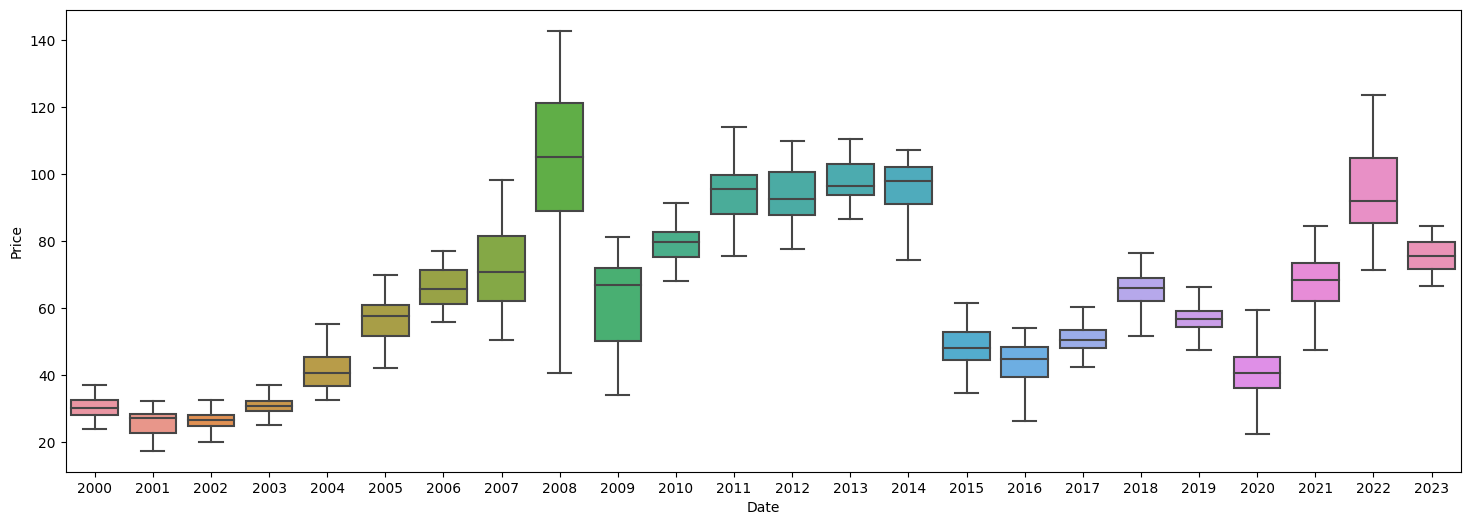

In [300]:
#After capping of year wise outliers
plt.figure(figsize=(18,6))
# Boxplot for outliers
sns.boxplot(x=cleaned_oil_price_series.index.year,y=cleaned_oil_price_series.Price)

<Axes: xlabel='Date', ylabel='Price'>

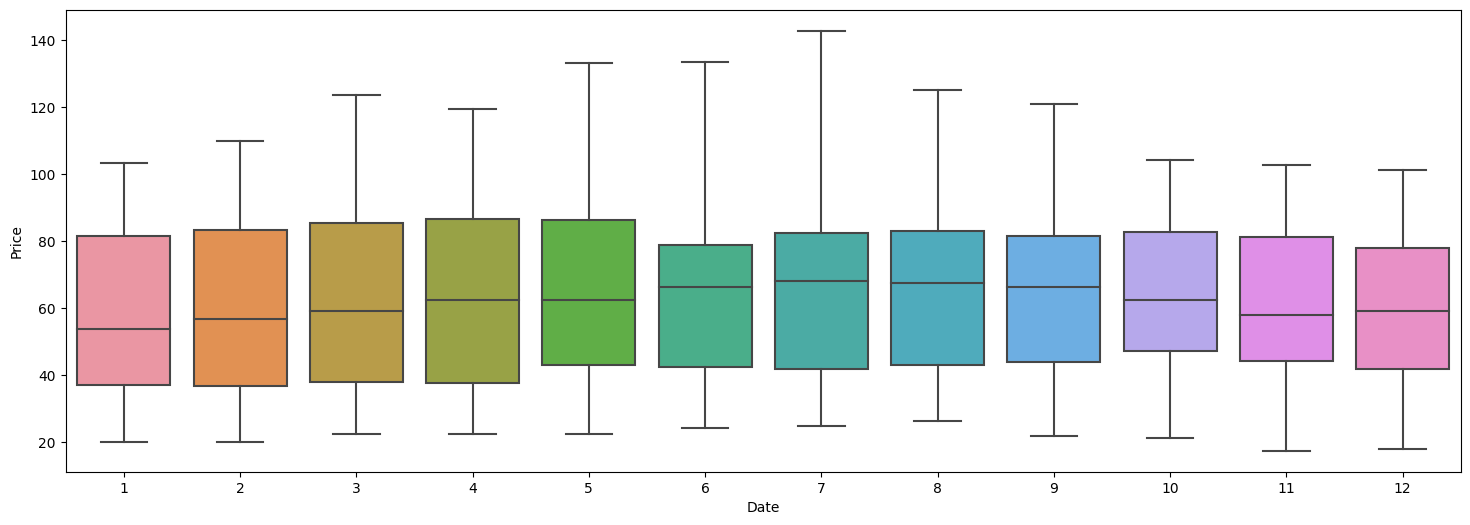

In [301]:
plt.figure(figsize=(18,6))
# Boxplot for outliers
sns.boxplot(x=cleaned_oil_price_series.index.month,y=cleaned_oil_price_series.Price)

##Data Visualization

###Line Plot

<Axes: xlabel='Date', ylabel='Price'>

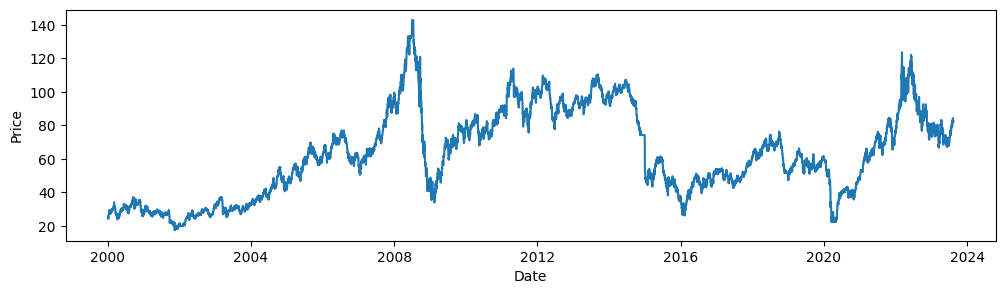

In [302]:
#Date wise line plot
plt.figure(figsize=(12,3))
sns.lineplot(x='Date', y='Price',data=cleaned_oil_price_series)

Observation : Line plot shows how the Price values are changing during years.

###Histogram Plot

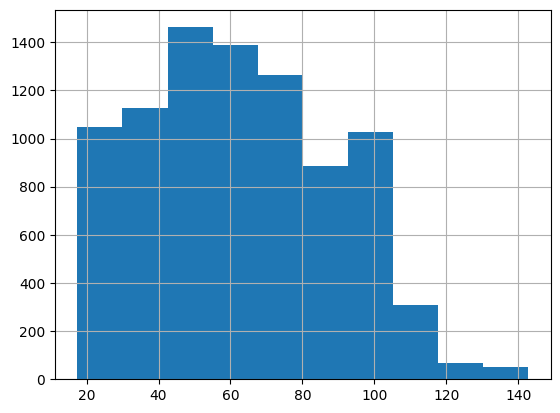

In [303]:
#histogram plot
cleaned_oil_price_series.Price.hist()
plt.show()

Observation : Hisogram plot shows that distribution is slightly right skewed.

###Density Plot

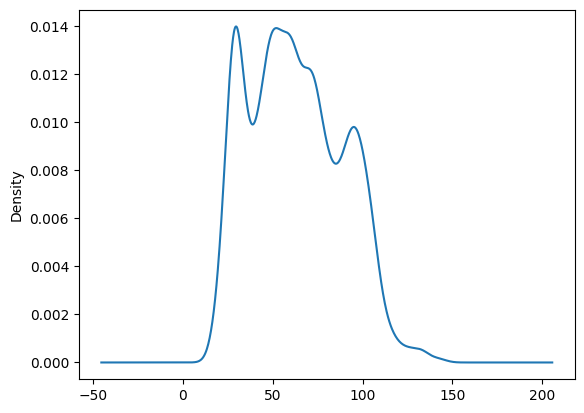

In [304]:
#Density Plot
cleaned_oil_price_series.Price.plot(kind='kde')
plt.show()

Observation : This Density plot has multiple peaks, that shows we have multiple modes in dataset.

###Box Plot

<Axes: >

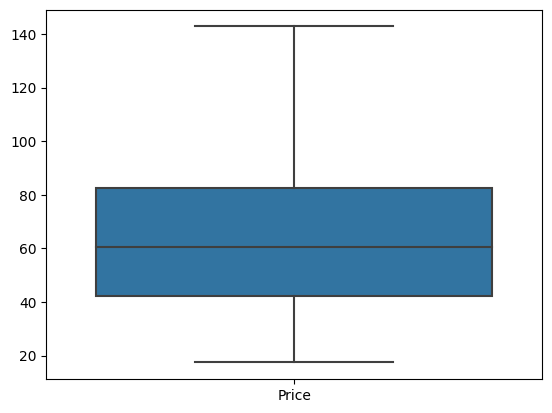

In [305]:
# Boxplot
sns.boxplot(cleaned_oil_price_series)

Observation: We can see no outliers present in dataset.

###Lag Plot

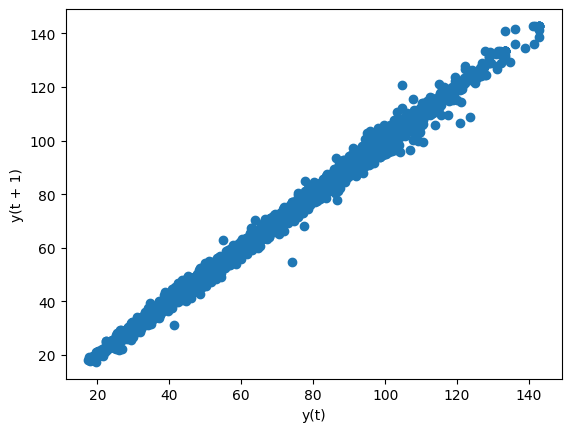

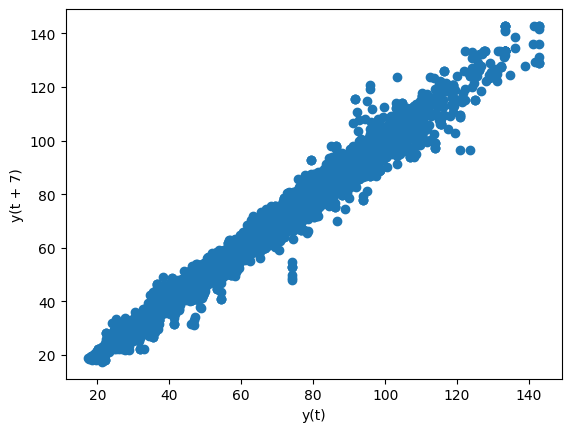

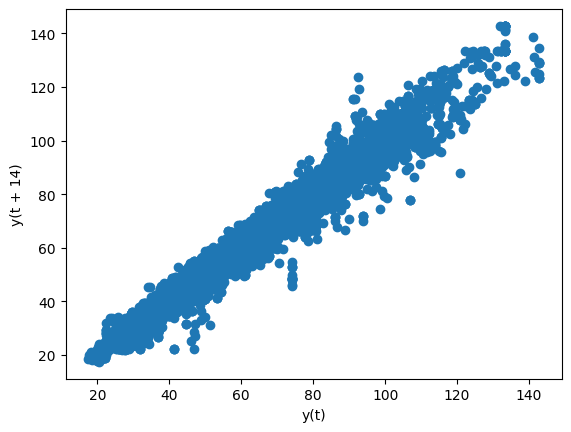

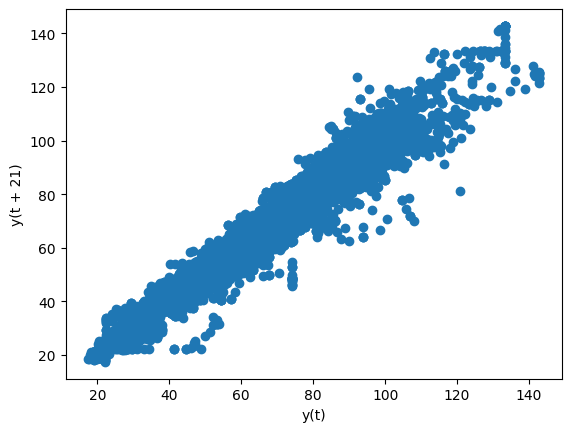

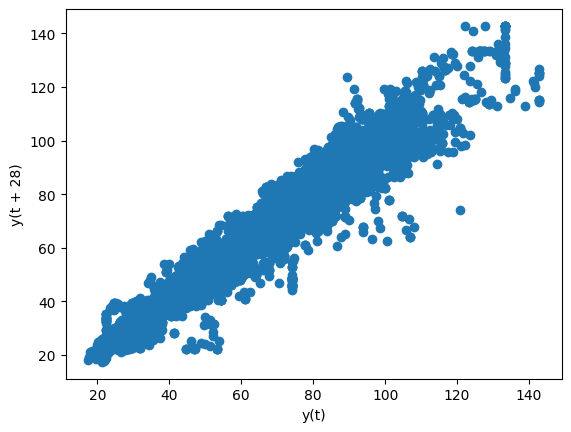

In [306]:
#Lag Plot for 1 day, 1 week, 2 weeks, 3 weeks, 4 weeks
for i in [1, 7, 14, 21, 28]:
    lag_plot(cleaned_oil_price_series.Price, lag=i)
    plt.show()

Observation : The points tend to cluster (not clear shape but noisily) along the diagonal. It shows moderate autocorrelation.

###Moving Average plot

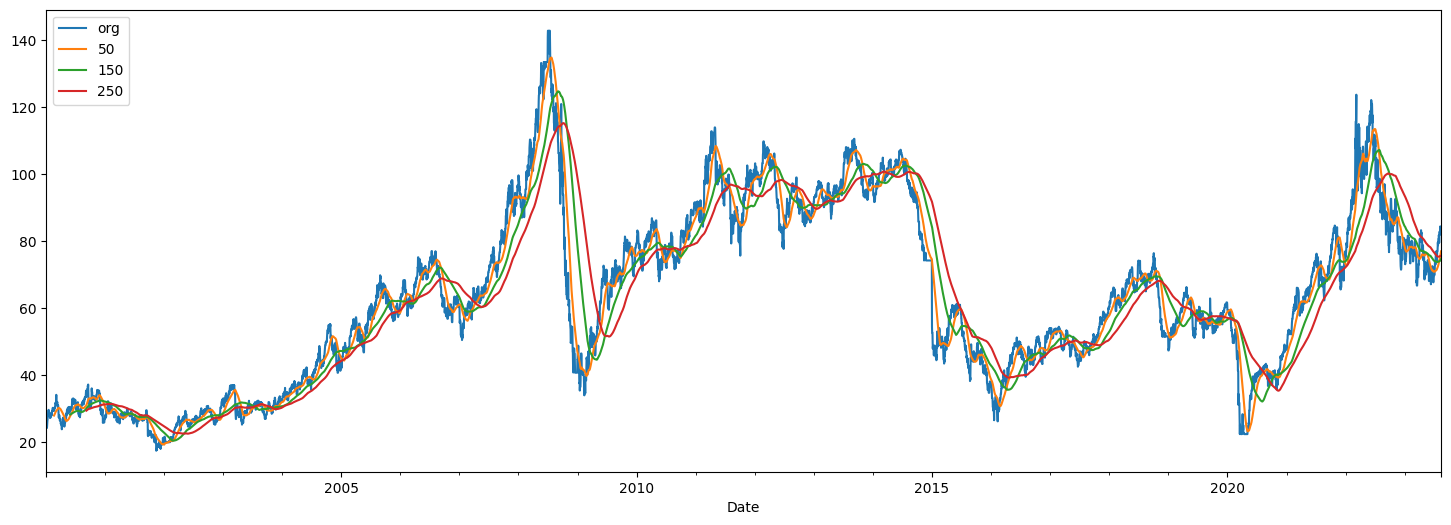

In [307]:
plt.figure(figsize=(18,6))
cleaned_oil_price_series.Price.plot(label='org')
for i in range(50,300,100):
    cleaned_oil_price_series.Price.rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

###Time series decomposition plot

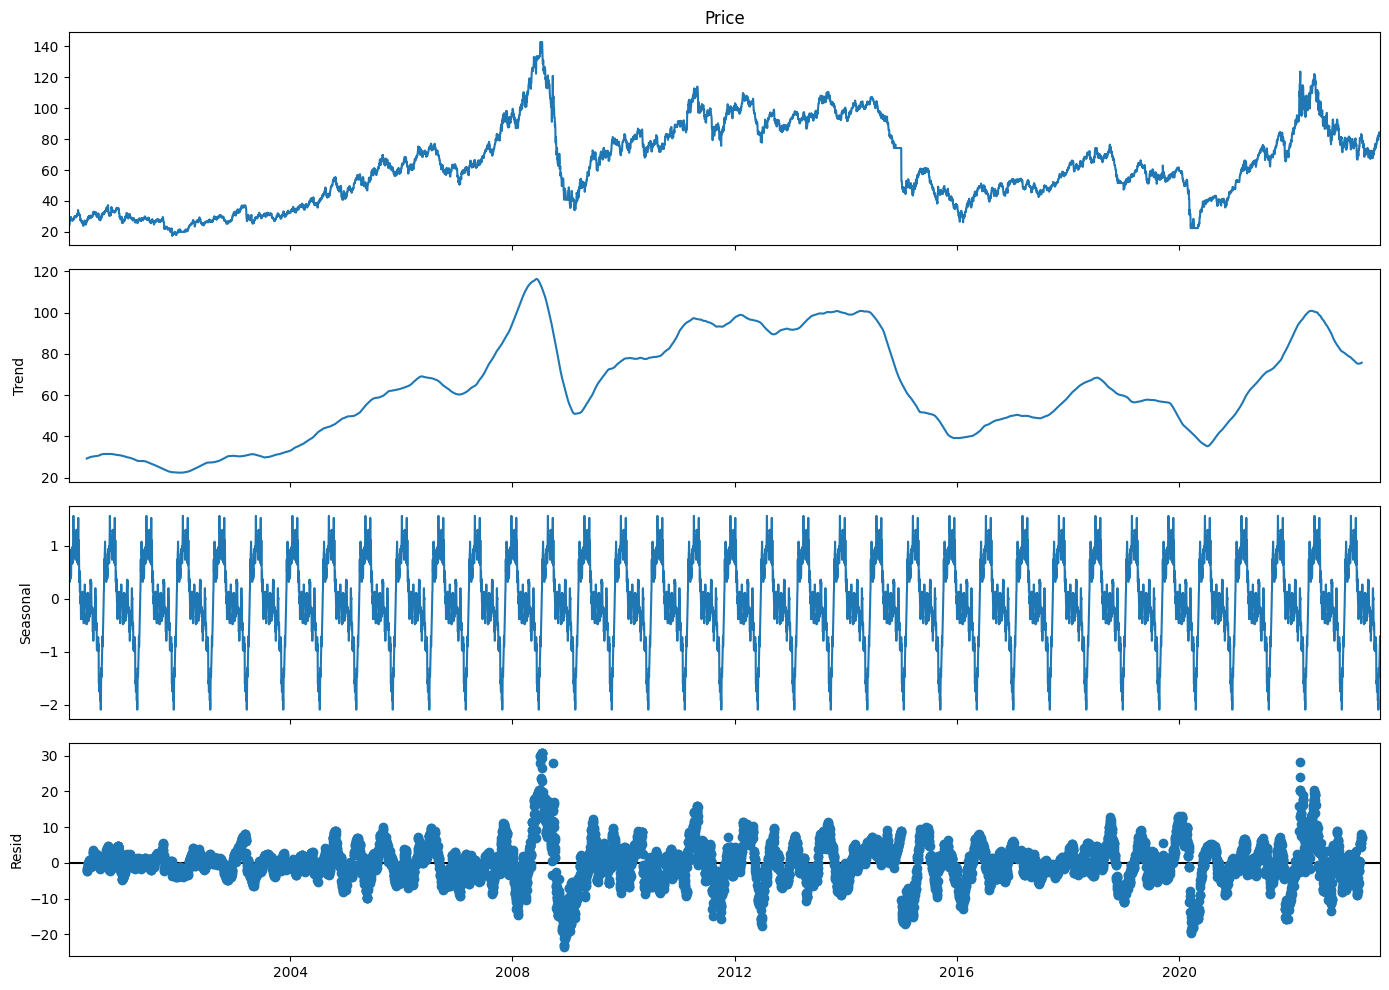

In [308]:
decompose_ts_add = seasonal_decompose(cleaned_oil_price_series.Price,model='additive',period=240)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

Observation : We can observe that no specific trend in dataset. Some monthly seasonality can be seen.

## Autocorrelation Analysis

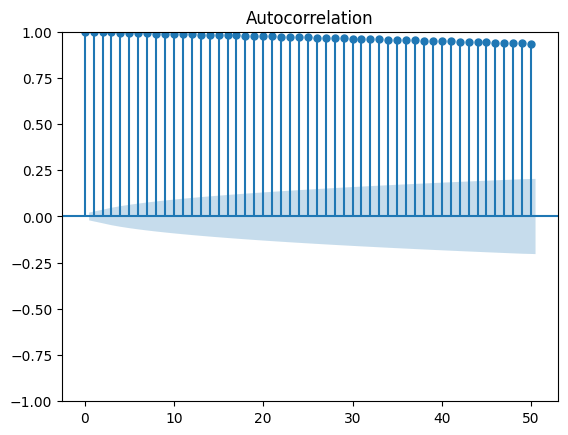

In [309]:
# Autocorrelation Function (ACF)
plot_acf(cleaned_oil_price_series.Price,lags=50)
plt.show()

Observation : The Autocorrelation plot shows time series has strong correlattion with its lagged version.But it started decreasing slowly subsequently.

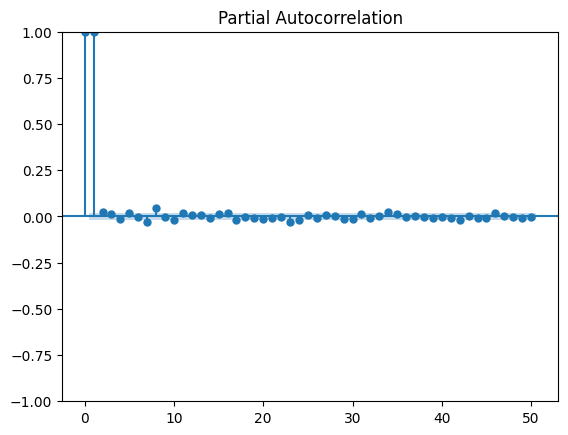

In [310]:
# Partial Autocorrelation Function (PACF)
plot_pacf(cleaned_oil_price_series.Price,lags=50)
plt.show()

Observation : The partial autocorrelation is strong between observations and their first lagged versions but it is weak at subsequent versions.

#5.	Spilting Train and Test data

In [311]:
#We will take 80 % data for training, and remaining for testing

train_size=int(80*len(cleaned_oil_price_series)/100)

#Splitting data into Train and Test
train_data = cleaned_oil_price_series.iloc[:train_size]
test_data = cleaned_oil_price_series.iloc[train_size:]

In [312]:
train_data

,Price
Date,
2000-01-04,25.55
2000-01-05,24.91
2000-01-06,24.78
2000-01-07,24.22
2000-01-08,24.22
...,...
2018-11-19,56.76
2018-11-20,53.43
2018-11-21,54.63


In [313]:
test_data

,Price
Date,
2018-11-24,51.56
2018-11-25,51.56
2018-11-26,51.63
2018-11-27,51.56
2018-11-28,51.56
...,...
2023-08-10,82.82
2023-08-11,83.19
2023-08-12,83.19


In [314]:
print('Shape of training data', train_data.shape)
print('Shape of testing data', test_data.shape)

Shape of training data (6899, 1)
Shape of testing data (1725, 1)


#6. Evaluation Metric

## MAPE- Mean Absolute Percent Error

In [315]:
# MAPE- Mean Absolute Percent Error
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp).round(2)

## RMSE - Root Mean Squred Error

In [316]:
# RMSE - Root Mean Squred Error
def RMSE(pred,org):
  MSE = np.square(np.subtract(org,pred)).mean()
  rmse = np.sqrt(MSE)
  return rmse.round(2)

# 7. Model Building

Before building any prediction model we will check the stationarity of time series

##Test of Stationarity

In [317]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    # As we have daily data, so taking window=240
    movingAverage = timeseries.rolling(window=240).mean()
    movingSTD = timeseries.rolling(window=240).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [318]:
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

##Stationarity check of Time Series

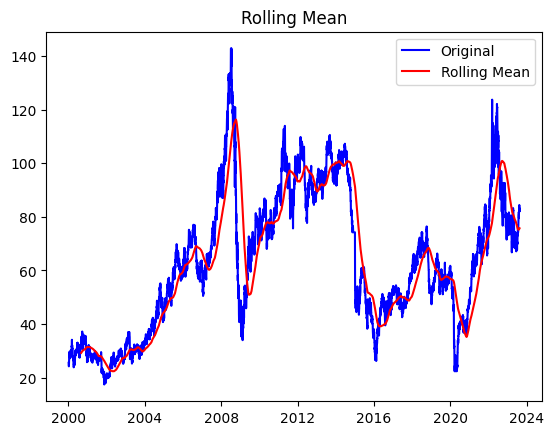

Results of Dickey Fuller Test:
Test Statistic                   -2.470255
p-value                           0.122880
#Lags Used                       23.000000
Number of Observations Used    8600.000000
Critical Value (1%)              -3.431111
Critical Value (5%)              -2.861876
Critical Value (10%)             -2.566949
dtype: float64
Fail to reject the null hypothesis
Data is non-stationary


In [319]:
test_stationarity(cleaned_oil_price_series)
adf_test(cleaned_oil_price_series)

**Hence the series is Non- Stationary.**




##Converting Non-Stationary Time Series into Stationary

###Differencing of the series

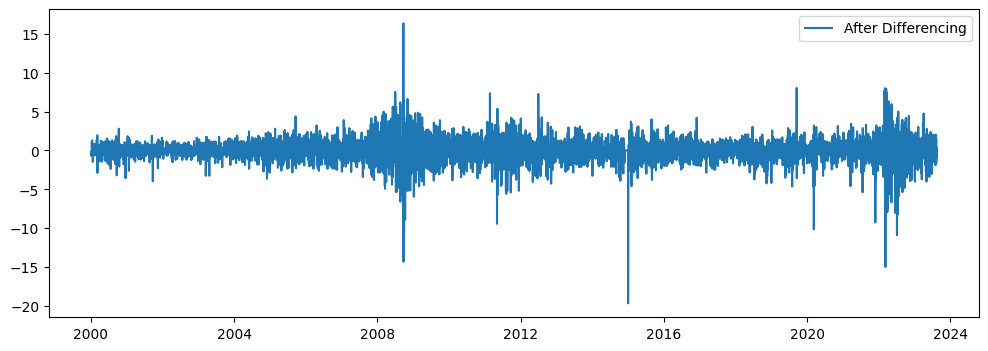

In [320]:
diff_series=cleaned_oil_price_series.copy()
diff_series['Diff_Price']=cleaned_oil_price_series['Price'].diff()
diff_series.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(diff_series['Diff_Price'], label='After Differencing')
plt.legend(loc='best')
plt.show()

Observation : We can see that there is no trend (upward or downward) after differencing.The mean is zero. Also, the variance is almost constant.

###Stationarity check of the Differencing

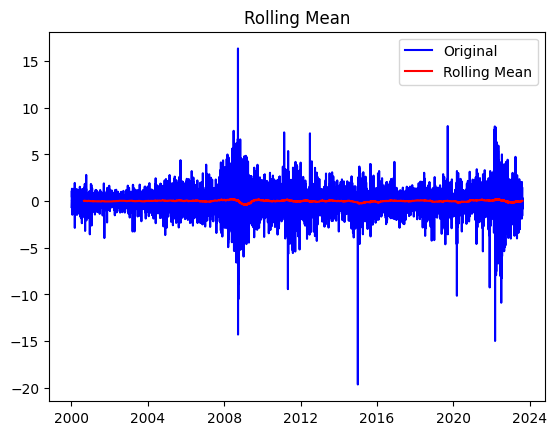

Results of Dickey Fuller Test:
Test Statistic                -1.789331e+01
p-value                        2.972036e-30
#Lags Used                     2.200000e+01
Number of Observations Used    8.600000e+03
Critical Value (1%)           -3.431111e+00
Critical Value (5%)           -2.861876e+00
Critical Value (10%)          -2.566949e+00
dtype: float64
Reject the null hypothesis
Data is stationary


In [321]:
test_stationarity(diff_series['Diff_Price'])
adf_test(diff_series['Diff_Price'])

Series has become Stationary after one differencing. We will use this series only further for model building.

In [322]:
diff_series

,Price,Diff_Price
Date,,
2000-01-05,24.91,-0.64
2000-01-06,24.78,-0.13
2000-01-07,24.22,-0.56
2000-01-08,24.22,0.00
2000-01-09,24.22,0.00
...,...,...
2023-08-10,82.82,-1.58
2023-08-11,83.19,0.37
2023-08-12,83.19,0.00


#Model Based Forecasting

In [323]:
# For Model based forecasting we will add some dummy features
diff_series=diff_series.copy()
diff_series['t'] = np.arange(1,len(diff_series)+1)
diff_series['t_squared'] = np.square(diff_series.t)
diff_series['log_price'] = np.log(diff_series['Price'])
diff_series.head(5)

,Price,Diff_Price,t,t_squared,log_price
Date,,,,,
2000-01-05,24.91,-0.64,1,1,3.215269
2000-01-06,24.78,-0.13,2,4,3.210037
2000-01-07,24.22,-0.56,3,9,3.187179
2000-01-08,24.22,0.00,4,16,3.187179
2000-01-09,24.22,0.00,5,25,3.187179


In [324]:
#Data Spiliting
diff_train_size=int(80*len(diff_series)/100)

#Splitting data into Train and Test
diff_train_data = diff_series.iloc[:diff_train_size]
diff_test_data = diff_series.iloc[diff_train_size:]

In [325]:
#Function to inverse Difference Series
def diff_inverse(series_diff):
  series_inverted = series_diff.cumsum()
  # Adding first datapoint as we shifted series
  series_inverted = series_inverted.add(test_data.Price[0])
  series_inverted.Price[0]=test_data.Price[0]

  return series_inverted

##Linear Model

In [326]:
#Linear Model
linear_model = smf.ols('Diff_Price~t',data=diff_train_data).fit()
pred_linear=test_data.copy()
pred_linear['Price'] =  pd.Series(linear_model.predict(pd.DataFrame(diff_test_data['t'])))
#inverse differencing
pred_linear=diff_inverse(pred_linear)

In [327]:
#Predicted Values
pred_linear.head()

,Price
Date,
2018-11-24,51.560000
2018-11-25,51.526322
2018-11-26,51.509474
2018-11-27,51.492620
2018-11-28,51.475760


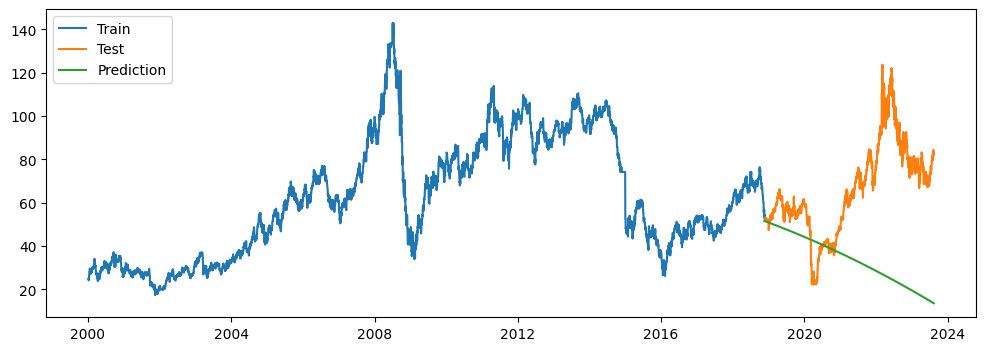

In [328]:
#Ploting of training, testing and Predicted data
plt.figure(figsize=(12,4))
plt.plot(diff_train_data['Price'], label='Train')
plt.plot(diff_test_data['Price'], label='Test')
plt.plot(pred_linear, label='Prediction')
plt.legend(loc='best')
plt.show()

In [329]:
#Errors
linear_mape= MAPE(pred_linear.Price,test_data.Price)
linear_rmse= RMSE(pred_linear.Price,test_data.Price)
print('MAPE = ',linear_mape)
print('RMSE = ',linear_rmse)

MAPE =  44.85
RMSE =  43.09


In [330]:
# DataFrame to compare models
results = pd.DataFrame({'Method':['Linear Model'],'MAPE':[linear_mape], 'RMSE':[linear_rmse] })

##Exponential Model

In [331]:
#Exponential Model
exp_model = smf.ols('log_price~t',data=diff_train_data).fit()
pred_exp=pd.DataFrame()
pred_exp['Price'] = np.exp(pd.Series(exp_model.predict(pd.DataFrame(diff_test_data['t']))))

In [332]:
#Predicted Values
pred_exp.head()

,Price
Date,
2018-11-24,87.584098
2018-11-25,87.595380
2018-11-26,87.606664
2018-11-27,87.617950
2018-11-28,87.629237


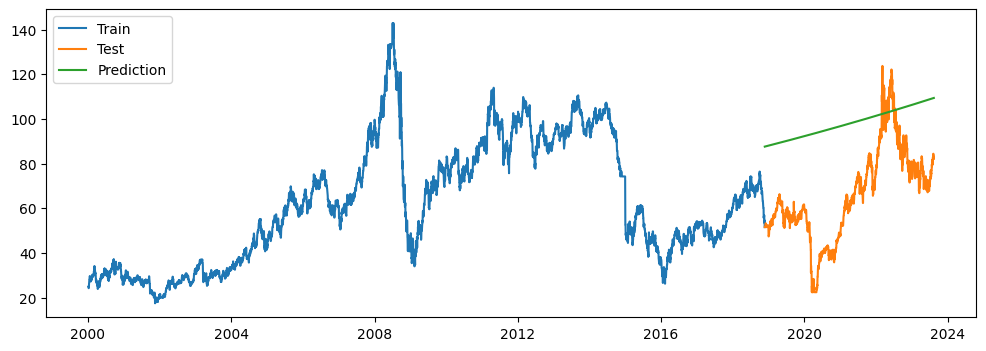

In [333]:
#Ploting of training, testing and Predicted data
plt.figure(figsize=(12,4))
plt.plot(diff_train_data['Price'], label='Train')
plt.plot(diff_test_data['Price'], label='Test')
plt.plot(pred_exp, label='Prediction')
plt.legend(loc='best')
plt.show()

In [334]:
#Errors
exp_mape= MAPE(pred_exp.Price,test_data.Price)
exp_rmse= RMSE(pred_exp.Price,test_data.Price)
print('MAPE = ',exp_mape)
print('RMSE = ',exp_rmse)

MAPE =  65.46
RMSE =  36.36


In [335]:
#Adding to DataFrame to compare models
results=results.append({'Method':'Exponential Model','MAPE':exp_mape, 'RMSE':exp_rmse }, ignore_index=True)

##Quadratic Model


In [336]:
#Quadratic Model
quad_model = smf.ols('Diff_Price~t+t_squared',data=diff_test_data).fit()
pred_quad=pd.DataFrame()
pred_quad['Price'] = pd.Series(quad_model.predict(diff_test_data[["t","t_squared"]]))
# Inverse Differencing
pred_quad=diff_inverse(pred_quad)

In [337]:
#Predicted Values
pred_quad.head()

,Price
Date,
2018-11-24,51.560000
2018-11-25,51.494789
2018-11-26,51.462435
2018-11-27,51.430249
2018-11-28,51.398231


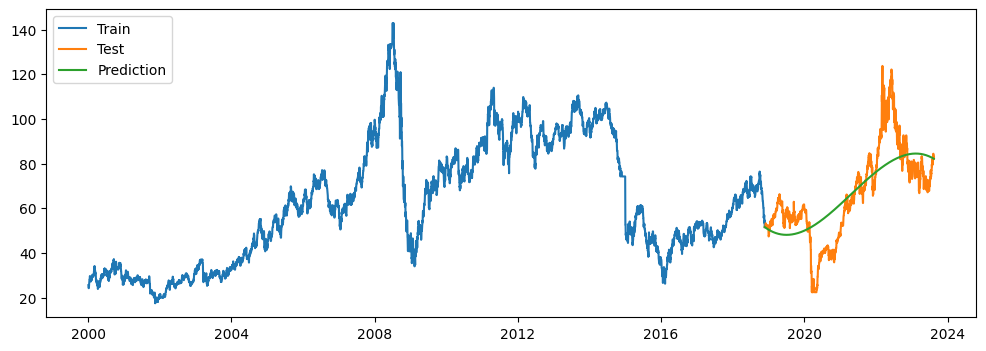

In [338]:
#Ploting of training, testing and Predicted data
plt.figure(figsize=(12,4))
plt.plot(train_data['Price'], label='Train')
plt.plot(test_data['Price'], label='Test')
plt.plot(pred_quad, label='Prediction')
plt.legend(loc='best')
plt.show()

In [339]:
#Errors
quad_mape= MAPE(pred_quad.Price,test_data.Price)
quad_rmse= RMSE(pred_quad.Price,test_data.Price)
print('MAPE = ',quad_mape)
print('RMSE = ',quad_rmse)

MAPE =  19.65
RMSE =  13.46


In [340]:
# Adding into DataFrame to compare models
results=results.append({'Method':'Quadratic Model','MAPE':quad_mape, 'RMSE':quad_rmse }, ignore_index=True)

#Forcasting using Data Driven Models

##Simple Exponential Smoothing Method

In [341]:
#Hyper Parameter Tuning of smoothing_level
def SES_parameter():
  best_ses_rmse= float('inf')
  best_smo_level= None
  for i in np.arange(0.1, 0.9, 0.1) :
    ses_model = SimpleExpSmoothing(diff_train_data["Price"]).fit(smoothing_level=i)
    pred_ses = ses_model.predict(start = diff_test_data.index[0], end = diff_test_data.index[-1])
    ses_rmse= RMSE(pred_ses,diff_test_data.Price)
    if ses_rmse < best_ses_rmse :
      best_ses_rmse=ses_rmse
      best_smo_level = i
  print('Minimum RMSE = ', best_ses_rmse, ' for smoothing level = ', best_smo_level)


In [342]:
#Calling function for SES model hyperparameter tuning
#SES_parameter()

Minimum RMSE =  22.19  for smoothing level =  0.1


Minimum RMSE =  22.19  for smoothing level =  0.1

In [343]:
#Simple Exponential model with optimized value of smoothing_level

ses_model = SimpleExpSmoothing(diff_train_data["Price"]).fit(smoothing_level=0.1)
pred_ses=pd.DataFrame()
pred_ses['Price'] = ses_model.predict(start = diff_test_data.index[0], end = diff_test_data.index[-1])

ses_model.params

{'smoothing_level': 0.1,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 24.91,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [344]:
#Predicted Values
pred_ses.head()

,Price
2018-11-24,57.511466
2018-11-25,57.511466
2018-11-26,57.511466
2018-11-27,57.511466
2018-11-28,57.511466


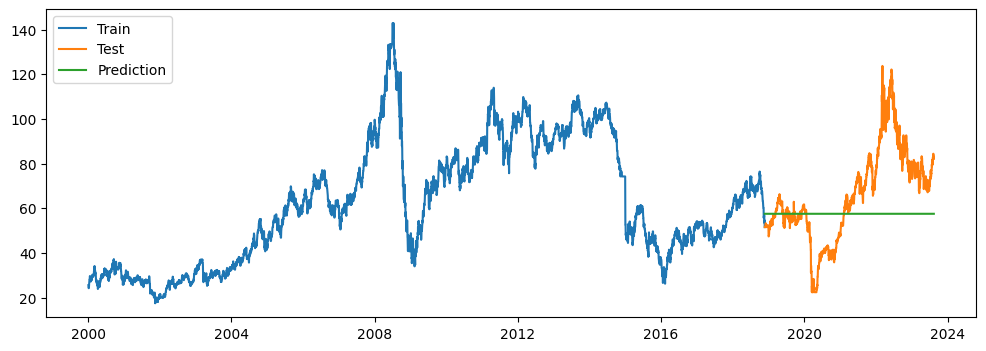

In [345]:
#Ploting of training, testing and Predicted data
plt.figure(figsize=(12,4))
plt.plot(train_data['Price'], label='Train')
plt.plot(test_data['Price'], label='Test')
plt.plot(pred_ses, label='Prediction')
plt.legend(loc='best')
plt.show()

In [346]:
#Errors
ses_mape= MAPE(pred_ses.Price,test_data.Price)
ses_rmse= RMSE(pred_ses.Price,test_data.Price)
print('MAPE = ',ses_mape)
print('RMSE = ',ses_rmse)

MAPE =  27.38
RMSE =  22.19


In [213]:
#Adding into DataFrame to compare models
results=results.append({'Method':'Simple Exponential Smoothing','MAPE':ses_mape, 'RMSE':ses_rmse }, ignore_index=True)

## Holt's method or Double Exponential Smoothing Method

In [347]:
#Hyper Parameter Tuning of smoothing_level and smoothing_slope
def Holt_Parameters() :
  best_ses_rmse= float('inf')
  best_smo_level, best_smo_slope= None, None
  for i in np.arange(0.1, 0.9, 0.1) :
    for j in np.arange(0.0, 0.9, 0.1) :
      ses_model = Holt(diff_train_data["Price"]).fit(smoothing_level=i, smoothing_slope=j)
      pred_ses = ses_model.predict(start = diff_test_data.index[0], end = diff_test_data.index[-1])
      ses_rmse= RMSE(pred_ses,diff_test_data.Price)
      if ses_rmse < best_ses_rmse :
        best_ses_rmse=ses_rmse
        best_smo_level, best_smo_slope = i, j

  print('Minimum RMSE = ', best_ses_rmse, ' for smoothing level = ', best_smo_level, 'and smoothing slope = ', best_smo_slope )

In [348]:
#Calling function for tuning of Holt's model parameters
#Holt_Parameters()

Minimum RMSE =  145.6  for smoothing level =  0.1 and smoothing slope =  0.0


Minimum RMSE =  145.6  for smoothing level =  0.1 and smoothing slope =  0.0

In [349]:
# Holt method with optimized parameters

holt_model = Holt(diff_train_data["Price"]).fit(smoothing_level=0.1, smoothing_slope=0.0)
pred_holt=pd.DataFrame()
pred_holt['Price'] = holt_model.predict(start = diff_test_data.index[0],end = diff_test_data.index[-1])

holt_model.params

{'smoothing_level': 0.1,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 24.91,
 'initial_trend': -0.129999999999999,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [350]:
#Predicted Values
pred_holt.head()

,Price
2018-11-24,56.211466
2018-11-25,56.081466
2018-11-26,55.951466
2018-11-27,55.821466
2018-11-28,55.691466


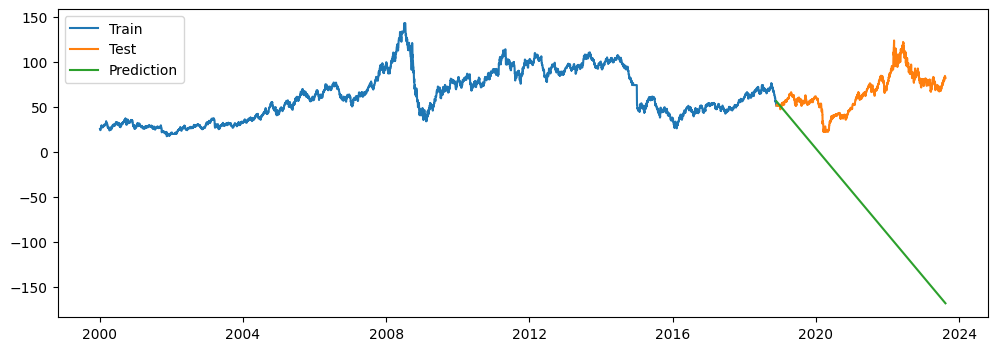

In [351]:
#Ploting of training, testing and Predicted data
plt.figure(figsize=(12,4))
plt.plot(train_data['Price'], label='Train')
plt.plot(test_data['Price'], label='Test')
plt.plot(pred_holt, label='Prediction')
plt.legend(loc='best')
plt.show()

In [352]:
#Errors
holt_mape= MAPE(pred_holt.Price,test_data.Price)
holt_rmse= RMSE(pred_holt.Price,test_data.Price)
print('MAPE = ',holt_mape)
print('RMSE = ',holt_rmse)

MAPE =  172.46
RMSE =  145.6


In [353]:
#Adding into DataFrame to compare models
results=results.append({'Method':'Holt\'s Exponential Smoothing','MAPE':holt_mape, 'RMSE':holt_rmse },ignore_index=True)

##Holt's Winter Exponential Smoothing

In [354]:
#Function for Hyper Parameter tuning of Holt's Winter Model
def HWE_Parameters():
  best_hwe_rmse= float('inf')
  best_sea, best_trend, best_period= None, None, None
  sea_param=['add', 'mul'] #seasonal parameter
  trend_param=['add', 'mul'] # trend parameter
  sp_param = [4,12,24,60]
  for i in sea_param :
    for j in trend_param :
      for k in sp_param :
        hwe_model = ExponentialSmoothing(diff_train_data["Price"],seasonal=i, trend=j, seasonal_periods=k).fit()
        pred_hwe = hwe_model.predict(start = diff_test_data.index[0], end = diff_test_data.index[-1])
        hwe_rmse= RMSE(pred_hwe,diff_test_data.Price)
        if hwe_rmse < best_hwe_rmse :
          best_hwe_rmse=hwe_rmse
          best_sea, best_trend, best_period= i, j, k
  print('Minimum RMSE = ', best_hwe_rmse, ' for seasonal = ', best_sea, ', trend = ', best_trend, ' and seasonal_period=', best_period )

In [355]:
#Calling Function of Hyper Parameter Tuning
#HWE_Parameters()

Minimum RMSE =  22.11  for seasonal =  mul , trend =  add  and seasonal_period= 4


Minimum RMSE =  22.11  for seasonal =  mul , trend =  add  and seasonal_period= 4

In [356]:
# Holt- Winter exponential model with optimized hyperparameter values
hwe_model = ExponentialSmoothing(diff_train_data["Price"],seasonal='mul',trend='add',seasonal_periods=4).fit() #add the trend to the model
pred_hwe = hwe_model.predict(start = diff_test_data.index[0],end = diff_test_data.index[-1])

In [357]:
#Predicted values
pred_hwe.head()

2018-11-24    51.672488
2018-11-25    51.711958
2018-11-26    51.711332
2018-11-27    51.700998
2018-11-28    51.688375
Freq: D, dtype: float64

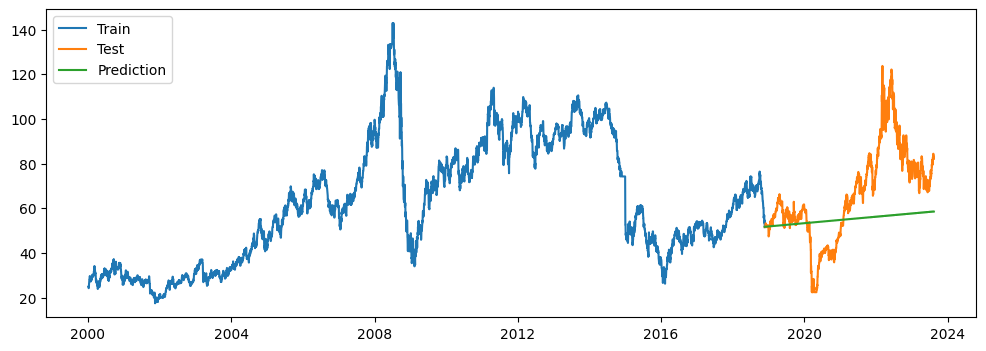

In [358]:
#Ploting of training, testing and Predicted data
plt.figure(figsize=(12,4))
plt.plot(diff_train_data['Price'], label='Train')
plt.plot(diff_test_data['Price'], label='Test')
plt.plot(pred_hwe, label='Prediction')
plt.legend(loc='best')
plt.show()

In [359]:
#Errors
hwe_mape= MAPE(pred_hwe,diff_test_data.Price)
hwe_rmse= RMSE(pred_hwe,diff_test_data.Price)
print('MAPE = ',hwe_mape)
print('RMSE = ',hwe_rmse)

MAPE =  26.39
RMSE =  22.11


In [360]:
#Adding into DataFrame to compare models
results=results.append({'Method':'Holt\'s Winter Exponential Smoothing Model','MAPE':hwe_mape, 'RMSE':hwe_rmse },ignore_index=True)

#ARIMA Model

##Auto Regressive Integrated Moving Average (ARIMA) Model

In [361]:
#Again taking DataFrame with only date and Price column as ARIMA model needs only univariate data
diff_price_data=diff_series[['Diff_Price']]

diff_train_data= diff_price_data[:train_size]
diff_test_data = diff_price_data[train_size:]

In [362]:
diff_test_data

,Diff_Price
Date,
2018-11-25,0.00
2018-11-26,0.07
2018-11-27,-0.07
2018-11-28,0.00
2018-11-29,0.00
...,...
2023-08-10,-1.58
2023-08-11,0.37
2023-08-12,0.00


####ARIMA Hyper Parameters Tuning



In [363]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.90)
    train, test = X[0:train_size], X[train_size:]
    arima_model = ARIMA(train, order=arima_order)
    arima_model_fit = arima_model.fit()
    predictions = list()
    predictions = arima_model_fit.predict(0, len(test))
# calculate error
    rmse = RMSE(predictions,test)
    return rmse

#Grid Search for p,d,q
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [364]:

#Code for Parameter Hypertuning
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#Uncomment below line to perform HyperParameter Tuning
#evaluate_models(diff_train_data.values, p_values, d_values, q_values)

The Best order is (0,0,0)

In [365]:
#Model with optimized values of hyperparameters p, d, q
arima_model = ARIMA(diff_train_data, order=(0, 0, 0))
arima_model_fit = arima_model.fit()
pred_arima = diff_test_data.copy()
pred_arima['Price'] = arima_model_fit.predict(diff_test_data.index.min(), diff_test_data.index.max())
#Inverse the differencing
pred_arima = diff_inverse(pred_arima)


In [366]:
#Predicted Values
pred_arima['Price'].head()

Date
2018-11-25    51.560000
2018-11-26    51.567530
2018-11-27    51.571295
2018-11-28    51.575060
2018-11-29    51.578825
Freq: D, Name: Price, dtype: float64

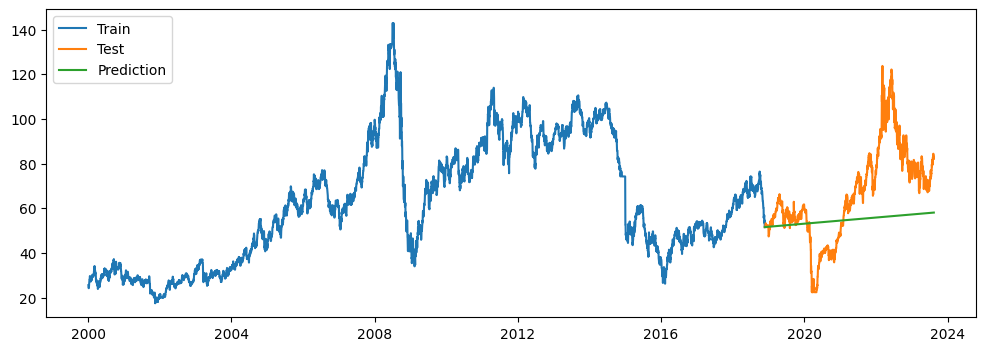

In [367]:
#Ploting of training, testing and Predicted data
plt.figure(figsize=(12,4))
plt.plot(train_data['Price'], label='Train')
plt.plot(test_data['Price'], label='Test')
plt.plot(pred_arima['Price'], label='Prediction')
plt.legend(loc='best')
plt.show()

In [368]:
#Errors
arima_mape= MAPE(pred_arima['Price'][diff_test_data.index.min():],test_data.Price)
arima_rmse= RMSE(pred_arima['Price'][diff_test_data.index.min():],test_data.Price)
print('MAPE = ',arima_mape)
print('RMSE = ',arima_rmse)

MAPE =  26.58
RMSE =  22.32


In [369]:
#Adding into DataFrame to compare models
results=results.append({'Method':'ARIMA Model','MAPE':arima_mape, 'RMSE':arima_rmse },ignore_index=True)

####Analysing the Residuals

In [370]:
#The mean of the Residual should be zero or close to Zero
arima_model_residual = arima_model_fit.resid
arima_model_residual.mean()

5.023764145852341e-06

In [371]:
#Residuals must be stationary
adf_test(arima_model_residual)

Reject the null hypothesis
Data is stationary


##Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [372]:
#Hyper Parameter Tuning of SARIMA model
def SarimaParameterTuning():
  warnings.filterwarnings("ignore")
  best_rmse, order, s_order= float('inf'), None, None
  p_param=[0,1,2]
  d_param=[1]
  q_param = [0,1,2]
  P_param= [0,1,2]
  D_param=[1]
  Q_param =[0,1,2]
  m_param=[4,6,12]
  for p in p_param :
    for d in d_param :
      for q in q_param :
        for P in P_param :
          for D in D_param :
            for Q in Q_param :
              for m in m_param:
                try :
                  sarima_model = SARIMAX(train_data, order=(p,d,q), seasonal_order=(P,D,Q,m)).fit()
                  pred_sarima=pd.DataFrame()
                  pred_sarima['Price'] = sarima_model.predict(start = test_data.index[0], end = test_data.index[-1])
                  sarima_rmse= RMSE(pred_sarima.Price,test_data.Price)
                  print('RMSE = ', sarima_rmse, ' ', p, d, q, P, D, Q, m)
                  if sarima_rmse < best_rmse :
                    best_rmse=sarima_rmse
                    order=(p,d,q)
                    s_order=(P,D,Q,m)

                except Exception as e:
                    print(e)
                    continue
  print('Minimum RMSE = ', best_rmse, ' for order = ', order ,' and seasonal_order = ', s_order )


In [373]:
#Function to perform SARIMA model's hyperparameter tuning
#Uncomment below line to perform HyperParameter Tuning

#SarimaParameterTuning()

Minimum RMSE =  18.91  for order =  (1, 1, 1)  and seasonal_order =  (0, 1, 0, 4)

In [374]:
#Building Sarima Model with Optimized code
#order p=1,d=1,q=1
#seasonal_order P=1, D=1, Q=0 and m=4
sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(0,1,0,4)).fit()
pred_sarima=pd.DataFrame()
pred_sarima['Price'] = sarima_model.predict(start = test_data.index[0], end = test_data.index[-1])

In [375]:
#Predicted Values
pred_sarima.head()

,Price
2018-11-24,49.650123
2018-11-25,51.883449
2018-11-26,52.025330
2018-11-27,50.112423
2018-11-28,48.600628


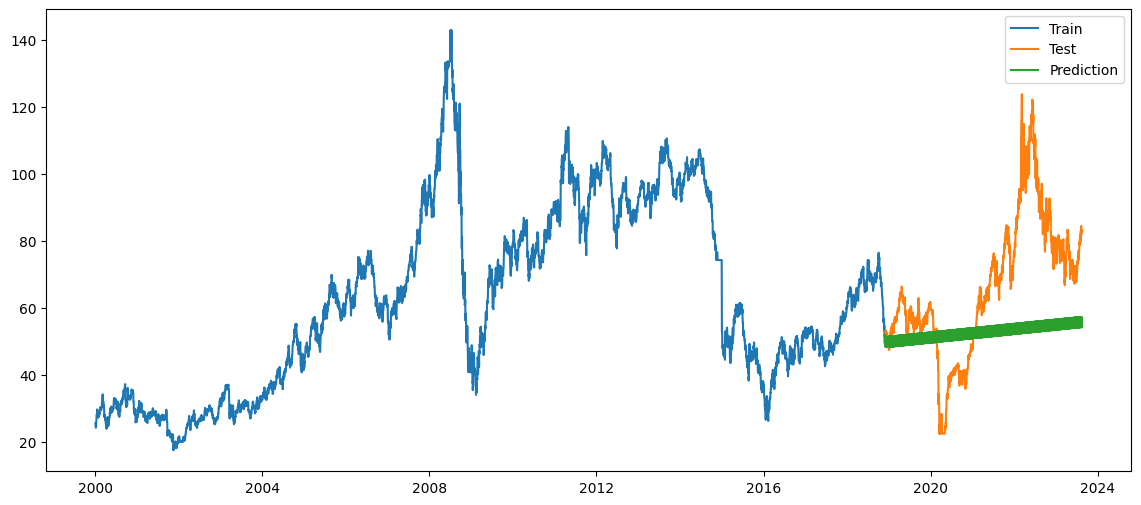

In [376]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Price'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_sarima['Price'], label='Prediction')
plt.legend(loc='best')
plt.show()

In [377]:
#Errors
sarima_mape= MAPE(pred_sarima['Price'][diff_test_data.index.min():],test_data.Price)
sarima_rmse= RMSE(pred_sarima['Price'][diff_test_data.index.min():],test_data.Price)
print('MAPE = ',sarima_mape)
print('RMSE = ',sarima_rmse)

MAPE =  27.66
RMSE =  23.4


In [378]:
#Adding into DataFrame to compare models
results=results.append({'Method':'Seasonal ARIMA Model','MAPE':sarima_mape, 'RMSE':sarima_rmse },ignore_index=True)

####Analysing the Residuals

In [379]:
#The mean of the Residual should be zero or close to Zero
sarima_model_residual = sarima_model.resid
sarima_model_residual.mean()

-0.006977992989473315

In [380]:
#Residuals must be stationary
adf_test(sarima_model_residual)

Reject the null hypothesis
Data is stationary


#FB PROPHET Model

In [381]:
#Creating copy of dataset for this model
prophet_data=cleaned_oil_price_series.copy()

#reset index as it does not require date as index
prophet_data =prophet_data.reset_index()

#renaming the column as per prophet api
prophet_data = prophet_data.rename(columns={'Date': 'ds', 'Price': 'y'})
prophet_data.head()

,ds,y
0,2000-01-04,25.55
1,2000-01-05,24.91
2,2000-01-06,24.78
3,2000-01-07,24.22
4,2000-01-08,24.22


In [382]:
#Spiliting data as train and test
train_size=int(80*len(prophet_data)/100)

#Splitting data into Train and Test
prophet_train_data = prophet_data.iloc[:train_size]
prophet_test_data = prophet_data.iloc[train_size:]

In [383]:
#Model Building
prophet_model = Prophet()
prophet_model.fit(prophet_train_data)
#Prediction
pred_fbp=prophet_test_data.copy()
pred_fbp=prophet_model.predict(prophet_test_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6a5syc0/dkpwk02e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6a5syc0/qgu2g4n_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63990', 'data', 'file=/tmp/tmpq6a5syc0/dkpwk02e.json', 'init=/tmp/tmpq6a5syc0/qgu2g4n_.json', 'output', 'file=/tmp/tmpq6a5syc0/prophet_model7pz4d__v/prophet_model-20230814071138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:11:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:11:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [384]:
#Predicted Values
pred_fbp[['ds','yhat']].head()

,ds,yhat
0,2018-11-24,59.881832
1,2018-11-25,59.842426
2,2018-11-26,59.752750
3,2018-11-27,59.681934
4,2018-11-28,59.688086


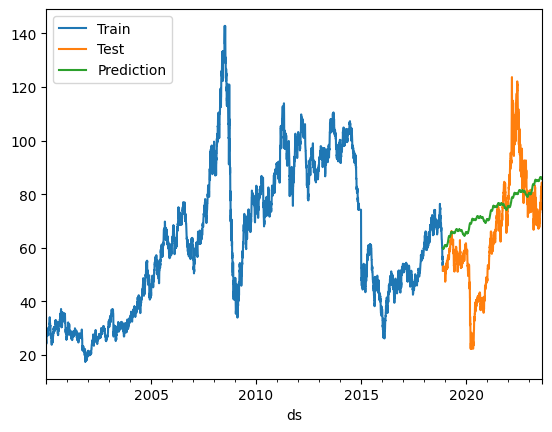

In [385]:
#Ploting of training, testing and Predicted data

ax1=prophet_train_data.plot(x='ds', y='y', label='Train')
prophet_test_data.plot(x='ds',y='y', label='Test', ax=ax1)
pred_fbp.plot(x='ds', y='yhat', label='Prediction', ax=ax1)
plt.legend(loc='best')
plt.show()

In [386]:
#Errors
fbp_mape= MAPE(pred_fbp.yhat.values,prophet_test_data.y.values)
fbp_rmse= RMSE(pred_fbp.yhat.values,prophet_test_data.y.values)
print('MAPE = ',fbp_mape)
print('RMSE = ',fbp_rmse)

MAPE =  29.55
RMSE =  18.52


In [387]:
#Adding into DataFrame to compare models
results=results.append({'Method':'FB Prophet Model','MAPE':fbp_mape, 'RMSE':fbp_rmse },ignore_index=True)

#Long short-term memory (LSTM) Model

In [388]:
#Sampling of datapoints to arrange in proper input/ output pattern
def sampling(sequence, n_steps):

  X, Y = list(), list()
  for i in range(len(sequence)):
    sam = i + n_steps
    if sam > len(sequence)-1:
      break
    x, y = sequence[i:sam], sequence[sam]
    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [389]:
#No of datapoints to taken as input
n_steps = 3
#No of features
n_features=1
#Creating sample list for train and test data
X_train, Y_train = sampling(train_data['Price'].tolist(), n_steps)
X_test, Y_test = sampling(test_data['Price'].tolist(), n_steps)

In [390]:
#First 5 Train data for LSTM
for i in range(0,5,1):

  print(X_train[i], Y_train[i])

[25.55 24.91 24.78] 24.22
[24.91 24.78 24.22] 24.22
[24.78 24.22 24.22] 24.22
[24.22 24.22 24.22] 24.67
[24.22 24.22 24.67] 25.77


In [392]:
# First 5 Test data for LSTM
for i in range(0,5,1):

  print(X_test[i], Y_test[i])

[51.56 51.56 51.63] 51.56
[51.56 51.63 51.56] 51.56
[51.63 51.56 51.56] 51.56
[51.56 51.56 51.56] 51.56
[51.56 51.56 51.56] 51.56


In [393]:
#Reshaping of datapoints as per required input of LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

HyperTuning of hyper parameters

In [394]:
#Hypertuning of activation function and No of Neurons parameters

def create_model(neuron1,activation_function):
  model = Sequential()
  model.add(LSTM(neuron1, activation=activation_function, input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

def LSTM_Parameters():

  # Create the model
  model = KerasRegressor(build_fn = create_model,verbose = 0,epochs = 200)

  # Define the grid search parameters
  neuron1 = [64,32,16,8]
  activation_function = ['softmax','relu','tanh','linear']

  # Make a dictionary of the grid search parameters
  param_grids = dict(neuron1 = neuron1,activation_function = activation_function)

  # Build and fit the GridSearchCV
  grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
  grid_result = grid.fit(X_train,Y_train)

  # Summarize the results
  print('Best Score : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))

In [395]:
#Calling Function for tuning of  hyper parameters
#LSTM_Parameters()

Best Score : -1.405816948413849, using {'activation_function': 'relu', 'neuron1': 16}

In [396]:
#Creating Model with optimized values
lstm_model = Sequential()
lstm_model.add(LSTM(16, activation='relu', input_shape=(n_steps, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16)                1152      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [397]:
lstm_model.fit(X_train, Y_train, epochs=200, verbose=0)
pred_lstm = test_data[:-3].copy()
pred_lstm['Price'] = lstm_model.predict(X_test, verbose=0)

In [398]:
#Predicted Values
pred_lstm.head()

,Price
Date,
2018-11-24,51.410030
2018-11-25,51.362629
2018-11-26,51.356293
2018-11-27,51.353146
2018-11-28,51.353146


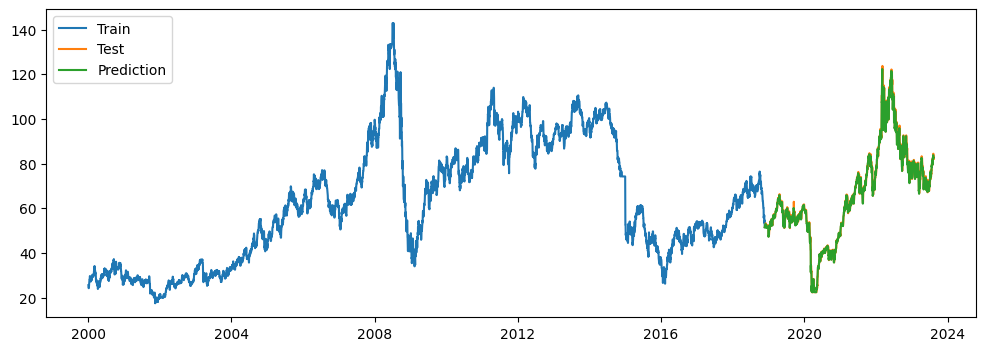

In [399]:
#Ploting of training, testing and Predicted data
plt.figure(figsize=(12,4))
plt.plot(train_data['Price'], label='Train')
plt.plot(test_data['Price'], label='Test')
plt.plot(pred_lstm['Price'], label='Prediction')
plt.legend(loc='best')
plt.show()

In [400]:
#Calculating Errors
lstm_mape= MAPE(pred_lstm.Price,test_data.Price[:-3])
lstm_rmse= RMSE(pred_lstm.Price,test_data.Price[:-3])
print('MAPE = ',lstm_mape)
print('RMSE = ',lstm_rmse)

MAPE =  1.91
RMSE =  2.03


In [401]:
#Adding into DataFrame to compare models
results=results.append({'Method':'LSTM Model','MAPE':lstm_mape, 'RMSE':lstm_rmse },ignore_index=True)

#Model Comparison

In [402]:
results.sort_values(['RMSE'], inplace=True, ignore_index=True)
results

,Method,MAPE,RMSE
0,LSTM Model,1.91,2.03
1,Quadratic Model,19.65,13.46
2,FB Prophet Model,29.55,18.52
3,Holt's Winter Exponential Smoothing Model,26.39,22.11
4,ARIMA Model,26.58,22.32
5,Seasonal ARIMA Model,27.66,23.40
6,Exponential Model,65.46,36.36
7,Linear Model,44.85,43.09
8,Holt's Exponential Smoothing,172.46,145.60


##Comparison Plot

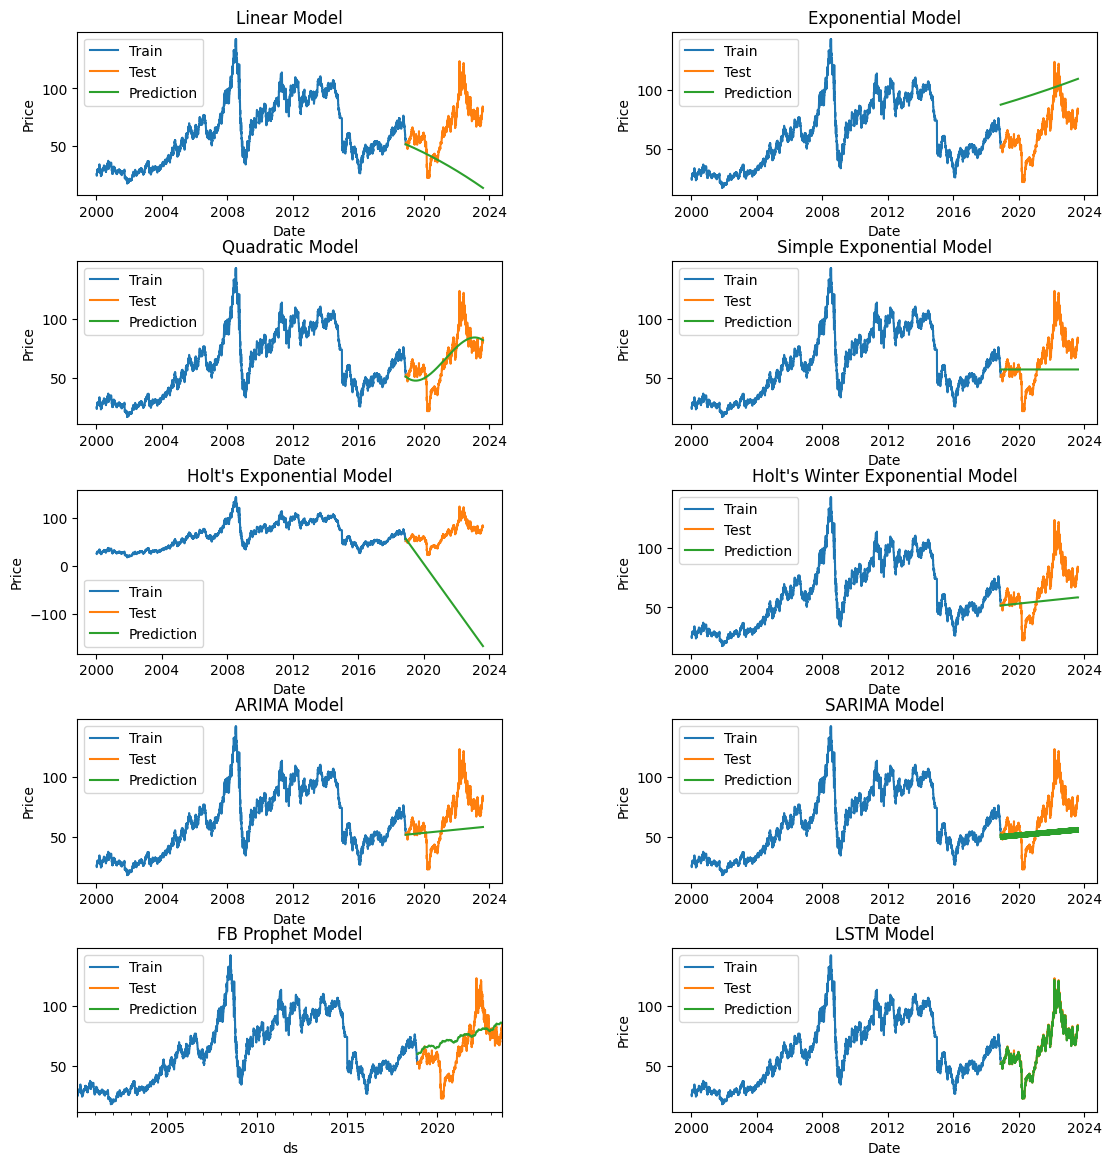

In [403]:
fig, ax = plt.subplots(5,2, figsize = (12,12))

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=1.0, wspace=0.4,  hspace=0.4)

sns.lineplot(train_data['Price'], label='Train',ax=ax[0,0])
sns.lineplot(test_data['Price'], label='Test', ax=ax[0,0])
sns.lineplot(pred_linear['Price'], label='Prediction', ax=ax[0,0]).set(
    title="Linear Model")

sns.lineplot(train_data['Price'], label='Train', ax=ax[0,1])
sns.lineplot(test_data['Price'], label='Test', ax=ax[0,1])
sns.lineplot(pred_exp['Price'], label='Prediction',ax=ax[0,1]).set(
    title="Exponential Model")

sns.lineplot(train_data['Price'], label='Train',ax=ax[1,0])
sns.lineplot(test_data['Price'], label='Test', ax=ax[1,0])
sns.lineplot(pred_quad['Price'], label='Prediction', ax=ax[1,0]).set(
    title="Quadratic Model")

sns.lineplot(train_data['Price'], label='Train', ax=ax[1,1])
sns.lineplot(test_data['Price'], label='Test', ax=ax[1,1])
sns.lineplot(pred_ses['Price'], label='Prediction', ax=ax[1,1]).set(
    title="Simple Exponential Model")

sns.lineplot(train_data['Price'], label='Train', ax=ax[2,0])
sns.lineplot(test_data['Price'], label='Test',  ax=ax[2,0])
sns.lineplot(pred_holt['Price'], label='Prediction', ax=ax[2,0]).set(
    title="Holt's Exponential Model")

sns.lineplot(train_data['Price'], label='Train', ax=ax[2,1])
sns.lineplot(test_data['Price'], label='Test', ax=ax[2,1])
sns.lineplot(pred_hwe, label='Prediction', ax=ax[2,1]).set(
    title="Holt's Winter Exponential Model")

sns.lineplot(train_data['Price'], label='Train', ax=ax[3,0])
sns.lineplot(test_data['Price'], label='Test', ax=ax[3,0])
sns.lineplot(pred_arima['Price'], label='Prediction', ax=ax[3,0]).set(
    title="ARIMA Model")

sns.lineplot(train_data['Price'], label='Train' , ax=ax[3,1])
sns.lineplot(test_data['Price'], label='Test', ax=ax[3,1])
sns.lineplot(pred_sarima['Price'], label='Prediction', ax=ax[3,1]).set(
    title="SARIMA Model")

prophet_train_data.plot(x='ds', y='y', label='Train', ax=ax[4,0] )
prophet_test_data.plot(x='ds',y='y', label='Test', ax=ax[4,0])
pred_fbp.plot(x='ds', y='yhat', label='Prediction', ax=ax[4,0]).set(
    title="FB Prophet Model")

sns.lineplot(train_data['Price'], label='Train', ax=ax[4,1])
sns.lineplot(test_data['Price'], label='Test', ax=ax[4,1])
sns.lineplot(pred_lstm['Price'], label='Prediction', ax=ax[4,1]).set(
    title="LSTM Model")

plt.show()


**LSTM Model has performed best here with minimum MAPE and RMSE**

#Final Model : LSTM

In [404]:
#LSTM Model
n_steps = 3
#Creating sample list for whole data
X, Y = sampling(cleaned_oil_price_series['Price'].tolist(), n_steps)


#Reshaping of datapoints as per required input of LSTM model
X = X.reshape((X.shape[0], X.shape[1], 1))

In [405]:
#Creating Model
n_features=1
lstm_model = Sequential()
lstm_model.add(LSTM(16, activation='relu', input_shape=(n_steps, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X, Y, epochs=200, verbose=0)


In [406]:
# serialize model to JSON
model_json = lstm_model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [408]:
#loading model from json file for testing purpose
# load json and create model
json_file = open('lstm_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [409]:
pred = test_data[:-3].copy()
pred['Price'] = lstm_model.predict(X_test, verbose=0)
rmse= RMSE(pred_lstm.Price,test_data.Price[:-3])
print('RMSE of saved model : ', rmse)

RMSE of saved model :  2.03


Observation : RMSE is the same before and after saving model in json model